RandomForestClassifier/XGBClassifier/MLPClassifier with Shap

In [142]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import shap
from xgboost import XGBClassifier, DMatrix
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier
import json

In [143]:
# Categories of interest = {"Generic policy", "Reporting mechanism", "Scope of practice", "User guideline"}

selected_categories = 'Generic policy'

# Load datasets
df_train = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_train.json')
df_val = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_val.json')
df_test = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_test.json')

# df_train = pd.read_json(f'set/for_modeling/train.json')
# df_val = pd.read_json(f'set/for_modeling/validation.json')
# df_test = pd.read_json(f'set/for_modeling/test.json')

#scale up the dataset
# df_train = pd.concat([df_train, df_train])
# df_val = pd.concat([df_val, df_val])
# df_test = pd.concat([df_test, df_test])

In [144]:
# Categories
categories = [
    'Generic policy', 'Reporting mechanism', 'Information on maintainer', 
    'Scope of practice', 'Project practice', 'History of vulnerability', 
    'User guideline', 'Additional information',
]

for category in categories:
    df_train[category] = df_train['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)
    df_val[category] = df_val['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)
    df_test[category] = df_test['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)

        
# Features
selected_features = ['num_commits', 'project_age_days', 'num_contributors', 
                     'num_issues', 'num_pull', 'num_opening_issue', 'project_size(kB)', 
                     'num_stargazers', 'num_watchers', 'num_forks', 'num_subscribers']

# Change category to be trained here
X_train, y_train = df_train[selected_features], df_train[selected_categories]
X_val, y_val = df_val[selected_features], df_val[selected_categories]
X_test, y_test = df_test[selected_features], df_test[selected_categories]

# print(y_train.value_counts())
# print(y_val.value_counts())
# print(y_test.value_counts())

In [145]:
# from imblearn.over_sampling import SMOTE
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score, train_test_split

# # Check class distribution before oversampling
# print("Before SMOTE:")
# print(y_train.value_counts())
# # print(y_val.value_counts())
# # print(y_test.value_counts())

# # Apply SMOTE to balance classes in training data
# smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)  # Keep a slight imbalance
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# # X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
# # X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# # Check class distribution after oversampling
# print("\nAfter SMOTE:")
# print(pd.Series(y_train_resampled).value_counts())
# # print(pd.Series(y_val_resampled).value_counts())
# # print(pd.Series(y_test_resampled).value_counts())


In [146]:
# Encode target variables
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


In [147]:
# #find the over fit point 

# # Define different complexities for each model
# rf_complexities = [10, 50, 100, 200, 300]  # n_estimators for RandomForest
# xgb_complexities = [50, 100, 200, 300, 500]  # n_estimators for XGB
# mlp_complexities = [50, 100, 200, 300, 500]  # max_iter (epochs) for MLP

# # Store results
# rf_train_acc, rf_val_acc = [], []
# xgb_train_acc, xgb_val_acc = [], []
# mlp_train_acc, mlp_val_acc = [], []

# # RandomForest Overfitting Analysis
# for n in rf_complexities:
#     rf_clf = RandomForestClassifier(n_estimators=n, random_state=42)
#     rf_clf.fit(X_train, y_train)

#     rf_train_acc.append(accuracy_score(y_train, rf_clf.predict(X_train)))
#     rf_val_acc.append(accuracy_score(y_val, rf_clf.predict(X_val)))

# # XGBoost Overfitting Analysis
# for n in xgb_complexities:
#     xgb_clf = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss', random_state=42)
#     xgb_clf.fit(X_train, y_train)

#     xgb_train_acc.append(accuracy_score(y_train, xgb_clf.predict(X_train)))
#     xgb_val_acc.append(accuracy_score(y_val, xgb_clf.predict(X_val)))

# # MLP Overfitting Analysis
# for n in mlp_complexities:
#     mlp_clf = MLPClassifier(max_iter=n, random_state=42)
#     mlp_clf.fit(X_train, y_train)

#     mlp_train_acc.append(accuracy_score(y_train, mlp_clf.predict(X_train)))
#     mlp_val_acc.append(accuracy_score(y_val, mlp_clf.predict(X_val)))

# # Plot Training vs Validation Accuracy
# plt.figure(figsize=(12, 6))

# # RandomForest plot
# plt.subplot(1, 3, 1)
# plt.plot(rf_complexities, rf_train_acc, label="Train Accuracy", marker='o')
# plt.plot(rf_complexities, rf_val_acc, label="Validation Accuracy", marker='s')
# plt.xlabel("n_estimators (RF)")
# plt.ylabel("Accuracy")
# plt.title("RandomForest Overfitting Analysis")
# plt.legend()

# # XGBoost plot
# plt.subplot(1, 3, 2)
# plt.plot(xgb_complexities, xgb_train_acc, label="Train Accuracy", marker='o')
# plt.plot(xgb_complexities, xgb_val_acc, label="Validation Accuracy", marker='s')
# plt.xlabel("n_estimators (XGB)")
# plt.ylabel("Accuracy")
# plt.title("XGBoost Overfitting Analysis")
# plt.legend()

# # MLP plot
# plt.subplot(1, 3, 3)
# plt.plot(mlp_complexities, mlp_train_acc, label="Train Accuracy", marker='o')
# plt.plot(mlp_complexities, mlp_val_acc, label="Validation Accuracy", marker='s')
# plt.xlabel("max_iter (MLP)")
# plt.ylabel("Accuracy")
# plt.title("MLP Overfitting Analysis")
# plt.legend()

# plt.tight_layout()
# plt.show()


Random forest Classification

best parameter: https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/ 
and https://tahera-firdose.medium.com/fine-tuning-your-random-forest-classifier-a-guide-to-hyperparameter-tuning-d5ceab0c4852

In [148]:
# Train Random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.65
Validation Report:
              precision    recall  f1-score   support

           0       0.33      0.11      0.16        19
           1       0.69      0.90      0.78        41

    accuracy                           0.65        60
   macro avg       0.51      0.50      0.47        60
weighted avg       0.57      0.65      0.58        60

Test Accuracy: 0.71
Test Report:
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.73      0.90      0.81        21

    accuracy                           0.71        31
   macro avg       0.67      0.60      0.60        31
weighted avg       0.69      0.71      0.68        31



In [149]:
# # Define the classifier
# rf_clf = RandomForestClassifier()

# # Store classification reports and accuracies
# val_reports = []
# test_reports = []
# val_accuracies = []
# test_accuracies = []

# # Run the model 10 times
# for _ in range(100):
#     rf_clf.fit(X_train, y_train)
    
#     # Validation
#     y_val_pred = rf_clf.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     val_accuracies.append(val_accuracy)
#     val_report = classification_report(y_val, y_val_pred, output_dict=True)
#     val_reports.append(val_report)
    
#     # Testing
#     y_test_pred = rf_clf.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     test_accuracies.append(test_accuracy)
#     test_report = classification_report(y_test, y_test_pred, output_dict=True)
#     test_reports.append(test_report)

# # Compute average classification reports
# def average_classification_report(reports):
#     avg_report = {}
#     for label in reports[0].keys():
#         if isinstance(reports[0][label], dict):  # Normal classification labels
#             avg_report[label] = {
#                 metric: np.mean([r[label][metric] for r in reports]) for metric in reports[0][label]
#             }
#         else:  # Handle 'accuracy' separately (it's a float)
#             avg_report[label] = np.mean([r[label] for r in reports])
#     return avg_report

# avg_val_report = average_classification_report(val_reports)
# avg_test_report = average_classification_report(test_reports)

# # Convert results to DataFrame for visualization
# df_val_report = pd.DataFrame(avg_val_report).T
# df_test_report = pd.DataFrame(avg_test_report).T

# print('val Report:')
# print(df_val_report)


# print('test Report:')
# print(df_test_report)


100%|██████████| 31/31 [00:03<00:00,  8.06it/s]


Text(0.5, 32.10000000000005, 'SHAP value')

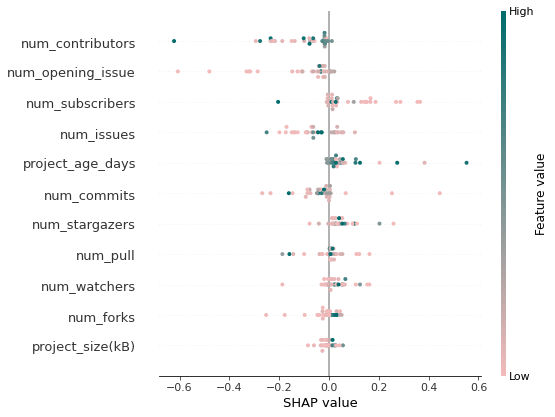

In [150]:
# Shap RF
explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

XGBoost Classification

params: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

In [151]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "n_estimators": [200, 300, 500],
#     "max_depth": [3, 4, 5],
#     "learning_rate": [0.01, 0.03, 0.05],
#     "min_child_weight": [3, 5, 7],
#     "gamma": [1, 3, 5]
# }

# grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train_resampled, y_train_resampled)

# print("Best Parameters:", grid_search.best_params_)


In [152]:

xg_clf = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.05, colsample_bytree=0.8, subsample=0.8)
xg_clf.fit(X_train, y_train)

# Validate XGB
y_val_pred = xg_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test XGB
y_test_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.65
Validation Report:
              precision    recall  f1-score   support

           0       0.42      0.26      0.32        19
           1       0.71      0.83      0.76        41

    accuracy                           0.65        60
   macro avg       0.56      0.55      0.54        60
weighted avg       0.62      0.65      0.62        60

Test Accuracy: 0.81
Test Report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.80      0.95      0.87        21

    accuracy                           0.81        31
   macro avg       0.82      0.73      0.75        31
weighted avg       0.81      0.81      0.79        31



In [153]:
# # Define the XGBoost classifier with specified parameters
# xg_clf = XGBClassifier()

# # Store classification reports and accuracies
# xgb_val_reports = []
# xgb_test_reports = []
# xgb_val_accuracies = []
# xgb_test_accuracies = []

# # Run the model 10 times
# for _ in range(100):
#     xg_clf.fit(X_train, y_train)

#     # Validation
#     y_val_pred = xg_clf.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)
#     xgb_val_accuracies.append(val_accuracy)
#     val_report = classification_report(y_val, y_val_pred, output_dict=True)
#     xgb_val_reports.append(val_report)

#     # Testing
#     y_test_pred = xg_clf.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     xgb_test_accuracies.append(test_accuracy)
#     test_report = classification_report(y_test, y_test_pred, output_dict=True)
#     xgb_test_reports.append(test_report)

# # Compute average classification reports
# avg_xgb_val_report = average_classification_report(xgb_val_reports)
# avg_xgb_test_report = average_classification_report(xgb_test_reports)

# # Convert results to DataFrame for visualization
# df_xgb_val_report = pd.DataFrame(avg_xgb_val_report).T
# df_xgb_test_report = pd.DataFrame(avg_xgb_test_report).T

# print('val Report:')
# print(df_xgb_val_report)

# print('test Report:')
# print(df_xgb_test_report)



Text(0.5, 32.10000000000005, 'SHAP value')

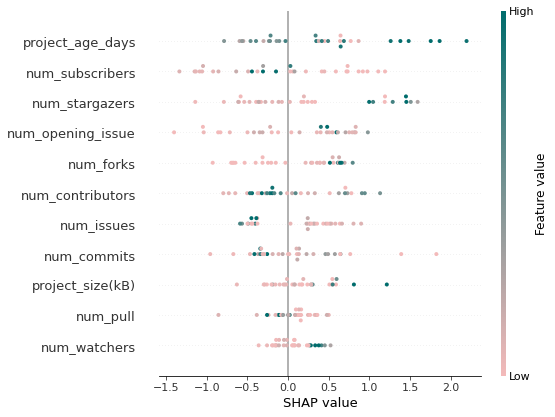

In [154]:
# Shap XGB
explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

NN MLPClassifier

In [155]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "activation": ["relu", "tanh", "logistic"],  # Activation functions
    "solver": ["adam", "sgd", "lbfgs"],  # Optimizers
    "alpha": [0.0001, 0.001, 0.01, 0.1],  # L2 regularization
    "learning_rate": ["constant", "adaptive", "invscaling"],  # Learning rate adjustments
    "learning_rate_init": [0.001, 0.01, 0.05],  # Initial learning rate
    "max_iter": [500, 1000, 1500],  # Training epochs
    "early_stopping": [True]  # Stop when validation accuracy stops improving
}

grid_search = GridSearchCV(MLPClassifier(), param_grid,n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


KeyboardInterrupt: 

In [ ]:
mlp_clf = MLPClassifier(learning_rate='invscaling')
mlp_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = mlp_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = mlp_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.58
Validation Report:
              precision    recall  f1-score   support

           0       0.38      0.47      0.42        19
           1       0.72      0.63      0.68        41

    accuracy                           0.58        60
   macro avg       0.55      0.55      0.55        60
weighted avg       0.61      0.58      0.59        60

Test Accuracy: 0.71
Test Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.75      0.86      0.80        21

    accuracy                           0.71        31
   macro avg       0.66      0.63      0.64        31
weighted avg       0.69      0.71      0.69        31



In [138]:
# Define the MLP classifier
mlp_clf = MLPClassifier(learning_rate='invscaling')

# Store classification reports and accuracies
mlp_val_reports = []
mlp_test_reports = []
mlp_val_accuracies = []
mlp_test_accuracies = []

# Run the model 10 times
for _ in range(10):
    mlp_clf.fit(X_train, y_train)

    # Validation
    y_val_pred = mlp_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    mlp_val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    mlp_val_reports.append(val_report)

    # Testing
    y_test_pred = mlp_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mlp_test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    mlp_test_reports.append(test_report)

# Compute average classification reports
avg_mlp_val_report = average_classification_report(mlp_val_reports)
avg_mlp_test_report = average_classification_report(mlp_test_reports)

# Convert results to DataFrame for visualization
df_mlp_val_report = pd.DataFrame(avg_mlp_val_report).T
df_mlp_test_report = pd.DataFrame(avg_mlp_test_report).T

print('val Report:')
print(df_mlp_val_report)

print('test Report:')
print(df_mlp_test_report)


val Report:
              precision    recall  f1-score  support
0              0.328938  0.257895  0.281592    19.00
1              0.692328  0.773171  0.727704    41.00
accuracy       0.610000  0.610000  0.610000     0.61
macro avg      0.510633  0.515533  0.504648    60.00
weighted avg   0.577255  0.610000  0.586435    60.00
test Report:
              precision    recall  f1-score    support
0              0.452778  0.330000  0.363814  10.000000
1              0.718949  0.804762  0.755783  21.000000
accuracy       0.651613  0.651613  0.651613   0.651613
macro avg      0.585863  0.567381  0.559798  31.000000
weighted avg   0.633087  0.651613  0.629341  31.000000


100%|██████████| 31/31 [00:03<00:00, 10.17it/s]


Text(0.5, 32.10000000000005, 'SHAP value')

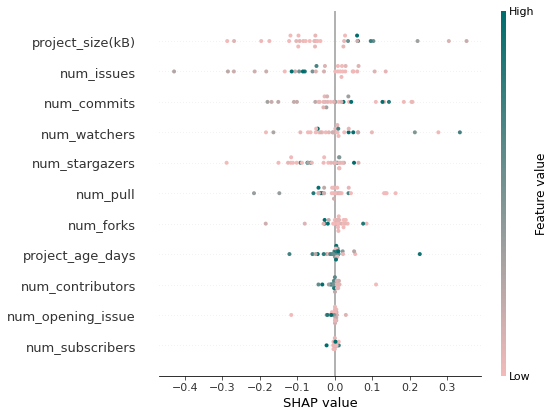

In [139]:
# Shap MLP
explainer = shap.KernelExplainer(mlp_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel(f"SHAP value")

In [140]:
from catboost import CatBoostClassifier, CatBoostRegressor

cat_clf = CatBoostClassifier()
cat_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = cat_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = cat_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Learning rate set to 0.005302
0:	learn: 0.6913402	total: 2.03ms	remaining: 2.03s
1:	learn: 0.6899964	total: 3.63ms	remaining: 1.81s
2:	learn: 0.6885220	total: 5.43ms	remaining: 1.8s
3:	learn: 0.6866848	total: 7.35ms	remaining: 1.83s
4:	learn: 0.6848736	total: 9.77ms	remaining: 1.94s
5:	learn: 0.6835240	total: 11.6ms	remaining: 1.93s
6:	learn: 0.6821094	total: 13.6ms	remaining: 1.93s
7:	learn: 0.6802191	total: 15.6ms	remaining: 1.93s
8:	learn: 0.6787593	total: 17.2ms	remaining: 1.9s
9:	learn: 0.6772961	total: 19ms	remaining: 1.88s
10:	learn: 0.6760650	total: 20.9ms	remaining: 1.88s
11:	learn: 0.6741219	total: 22.6ms	remaining: 1.86s
12:	learn: 0.6727523	total: 24.7ms	remaining: 1.88s
13:	learn: 0.6715953	total: 26.9ms	remaining: 1.89s
14:	learn: 0.6698811	total: 28.6ms	remaining: 1.88s
15:	learn: 0.6686609	total: 30.1ms	remaining: 1.85s
16:	learn: 0.6674726	total: 31.8ms	remaining: 1.84s
17:	learn: 0.6660597	total: 33.4ms	remaining: 1.82s
18:	learn: 0.6647030	total: 35.1ms	remaining: 1.

In [141]:
from catboost import CatBoostClassifier, Pool, cv

# Create a CatBoost Pool
catboost_pool = Pool(X, label=y)

# Define the parameters for the CatBoost model
params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 3,
    'loss_function': 'MultiClass',
    'random_state': 42,
}

# Perform cross-validation using the cv function from CatBoost
cv_results, cv_model = cv(
    pool=catboost_pool,
    params=params,
    # Specify the number of folds for cross-validation
    fold_count=5,  
    # Print information during training
    verbose=False, 
    return_models=True
)

NameError: name 'X' is not defined